In [38]:
# Model calling and intial setup
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser 
import warnings
warnings.filterwarnings("ignore") 

load_dotenv()
# Load env
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
AZURE_BASE_URL = os.getenv("AZURE_BASE_URL")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_CHAT_DEPLIOYMENT_NAME = os.getenv("AZURE_CHAT_DEPLIOYMENT_NAME")

parser = StrOutputParser()

llm_gemini = ChatGoogleGenerativeAI(model="gemini-2.0-flash" , api_key= GOOGLE_API_KEY)

llm_openai = AzureChatOpenAI(
    model="gpt-4o-mini",                         
    deployment_name=AZURE_CHAT_DEPLIOYMENT_NAME ,  # deployment name in Azure
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_BASE_URL,
    api_version="2024-02-01"
    )
llm_openai.invoke("What are your creater, also what type of LLM are you").content
# llm_gemini.invoke("who is father of india").content

c:\Users\singh\Let's Gooooo\Langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


"I was created by OpenAI, an organization focused on artificial intelligence research and deployment. I'm a language model based on the GPT-3.5 architecture, which is part of the Generative Pre-trained Transformer (GPT) series. My main function is to generate human-like text based on the input I receive, enabling me to assist with a wide range of queries, provide information, and engage in conversation."

### Simple First Parallel Workflows

In [ ]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict

class BatmanState(TypedDict):
    runs : int
    balls : int
    fours : int
    sixes : int
    sr : float
    bpb : float
    boudary_percantage : float
    summary : str

# InvalidUpdateError : In parallel workflow we can't send whole state, send partial state
def get_sr(state:BatmanState)->BatmanState:
    sr = (state['runs'] / state['balls'])*100
    # state['sr'] = sr Can't do that : InvalidUpdateError
    
    return {"sr" : sr} 

def get_bpb(state:BatmanState)->BatmanState:
    bpb = state['balls'] / (state['fours'] + state['sixes']) 
    # state['bpb'] = bpb
    
    return {"bpb" : bpb} # This is better, work with everytime

def get_bp(state:BatmanState)->BatmanState:
    bp = ((state['fours'] + state['sixes']) / state['balls'])*100
    # state['boudary_percantage'] = bp
    
    return {"boudary_percantage" : bp}

def get_summary(state:BatmanState)->BatmanState:
    summary = f"sr : {state['sr']}\nbpb : {state['bpb']}\nBp: {state['boudary_percantage']}"
    state['summary'] = summary
    return state

graph = StateGraph(BatmanState)

# Add Node
graph.add_node("Get_sr" ,get_sr)
graph.add_node("Get_bpb" , get_bpb)
graph.add_node("Get_bp" , get_bp)
graph.add_node("Summary" , get_summary)

# Add Edges
graph.add_edge(START , "Get_sr")
graph.add_edge(START , "Get_bpb")
graph.add_edge(START , "Get_bp")

graph.add_edge("Get_sr" , "Summary")
graph.add_edge("Get_bpb" , "Summary")
graph.add_edge("Get_bp" , "Summary")

graph.add_edge("Summary" , END)

first_workflow = graph.compile()

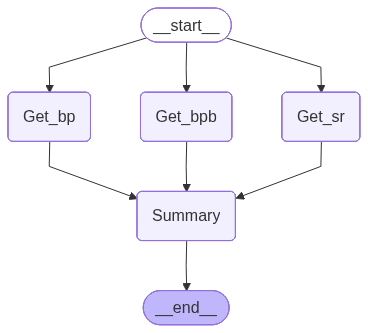

In [28]:
from IPython.display import Image
Image(first_workflow.get_graph().draw_mermaid_png())

In [31]:
print(first_workflow.invoke({"runs":55 , "balls":23 , "fours" : 4 , "sixes":4})['summary'])

sr : 239.1304347826087
bpb : 2.875
Bp: 34.78260869565217


### LLM Parellel workflow

In [56]:
# GET Blog Generation State
from typing import Annotated , List
from pydantic import BaseModel , Field
import operator


class BlogState(TypedDict):
    topic : str
    outline : str
    blog :str
    summary : str
    language_feedback : str
    anaylysis_feedback : str
    calrity_feeback : str
    overall_feedback : str
    individual_scores : Annotated[List[int] , operator.add] 
    final_score : float
    
class OutputScheme(BaseModel):
    feedback : str = Field(description="Provide a Detailed feedback of the Blog")
    Score : int = Field(description= "Score between 1-10 based on the feedback" , ge = 0 , le = 10)
    
llm_gemini_structured = llm_gemini.with_structured_output(OutputScheme)
results = llm_gemini_structured.invoke("This blog post effectively communicates important insights about the intersection of AI and the labor market in the tech industry. With careful attention to grammar, vocabulary richness, sentence variety, and tone adjustments, the post can be further polished for greater impact and engagement. Overall, these minor tweaks would enhance clarity and resonate more deeply with readers navigating these challenging dynamics.")

In [74]:
# GET Blog Generation State
from typing import Annotated , List
from pydantic import BaseModel , Field
import operator


class BlogState(TypedDict):
    topic : str
    outline : str
    blog :str
    summary : str
    language_feedback : str
    anaylysis_feedback : str
    calrity_feeback : str
    overall_feedback : str
    individual_scores : Annotated[List[int] , operator.add] 
    final_score : float
    
class OutputScheme(BaseModel):
    feedback : str = Field(description="Provide a Detailed feedback of the Blog")
    Score : int = Field(description= "Score between 1-10 based on the feedback" , ge = 0 , le = 10)
    
llm_gemini_structured = llm_gemini.with_structured_output(OutputScheme)

def get_outline(state:BlogState)->BlogState:
    promt = PromptTemplate(
        template="You're Subject matter Expert on the {topic}, Using all the resource you have generate a good outline to write a blog on {topic}. From starting to main part to Ending genarte a compehansive outline for the same",
        input_variables=['topic']
    )
    # Create Chain
    outline_chain = promt | llm_openai | parser
    
    # Invoke chain
    outline = outline_chain.invoke({"topic" : state['topic'] })
    state['outline'] = outline
    
    return state
\
def get_blog(state:BlogState)->BlogState:
    prompt = PromptTemplate(
        template="You're a Blog writter, Insprired from the modern Blog writing, you have to write a 300-500 word blog on the topic of {topic}, with the outline that is already give to you: \n {outline}. Make no mistake and factual Error",
        input_variables=['topic' , 'outline']
    )
    
    # Creating Chains
    blog_chain = prompt | llm_openai | parser
    # Invoke chain
    blog = blog_chain.invoke({'topic': state['topic'], 'outline': state['outline']})
    state['blog'] = blog
    return state

def get_summary(state:BlogState)->BlogState:
    prompt = PromptTemplate(
        template=" You have got the following Blog, make a small summary of this blog that capture essensce of that blog, make summary between 100-150 words, THis is the blog : \n {blog}",
        input_variables= ['blog']
    )
    
    # Create Chains
    summary_chain = prompt | llm_openai | parser
    
    # Invoke the chains
    summary = summary_chain.invoke({"blog" : state['blog']})
    state['summary'] = summary
    return state

def evalulate_language_feedback(state : BlogState)->BlogState:
    print("Running Language Feedback")
    prompt = PromptTemplate(
        template="You are an expert writing evaluator. Analyze the following blog post and provide language-related feedback. Focus on: grammar, vocabulary richness, sentence variety, tone, and overall readability, Blog : \n{blog}",
        input_variables= ['blog']
    )
    lf_chain = prompt | llm_gemini_structured 
    
    language_feedback = lf_chain.invoke({"blog" : state['blog']})
    
    return {"language_feedback" : language_feedback.feedback  , 'individual_scores' : [language_feedback.Score]}

def evalulate_analysis_feedback(state : BlogState)->BlogState:
    print("Running Analysis feedback")
    prompt = PromptTemplate(
        template="You are an expert in critical analysis and argument evaluation. Review the following blog post and give analysis-related feedback — focusing on: depth of reasoning, use of evidence, logical structure, and originality of ideas. Blog: \n{blog}",
        input_variables= ['blog']
    )
    af_chain = prompt | llm_gemini_structured
    
    analysis_feedback = af_chain.invoke({"blog" : state['blog']})
    
    return {"anaylysis_feedback" : analysis_feedback.feedback , "individual_scores" : [analysis_feedback.Score] }

def evalulate_clarity_feedback(state : BlogState)->BlogState:
    print("Running Clarity feedback")
    prompt = PromptTemplate(
        template="You are an expert writing coach. Evaluate this blog for clarity and coherence — focusing on whether the ideas are easy to follow, well-structured, and logically connected. Blog : \n{blog}",
        input_variables= ['blog']
    )
    cf_chain = prompt | llm_gemini_structured
    
    clarity_feedback = cf_chain.invoke({"blog" : state['blog']})
    
    return {"calrity_feeback" : clarity_feedback.feedback , "individual_scores" : [clarity_feedback.Score] }

def evalulate_overall_feedback(state : BlogState)->BlogState:
    prompt = PromptTemplate(
        template="You are a senior editor providing an overall evaluation of the blog post. Consider the 1) language feedback : \n{language_feedback} 2) Analysis feedback : \n {analysis_feedback} 3)  clarity feedback : \n {clarity_feedback}. based on these give me a final Evaluation of the blog.",
        input_variables= ['language_feedback' , 'analysis_feedback' , 'clarity_feedback']
    )
    final_eval_chain = prompt | llm_openai | parser
    
    overall_feedback = final_eval_chain.invoke({"language_feedback" : state['language_feedback'] ,"analysis_feedback" : state['anaylysis_feedback'], "clarity_feedback": state['calrity_feeback'] })
    
    # state['individual_scores'] = state['individual_scores'][:3]
    print(state['individual_scores'])
    state['overall_feedback'] = overall_feedback
    state['final_score'] = round(sum(state['individual_scores']) / len(state['individual_scores']) , 4)
    
    return state

# Define grapgh
graph = StateGraph(BlogState)

# Add Node
graph.add_node("Get_Outline", get_outline)
graph.add_node("Get_Blog" , get_blog)

graph.add_node("language_evalution" , evalulate_language_feedback)
graph.add_node("analysis_evalution" , evalulate_analysis_feedback)
graph.add_node("clarity_evalution" , evalulate_clarity_feedback)
graph.add_node("overall_evalution" , evalulate_overall_feedback)

# Add Edges
graph.add_edge(START , "Get_Outline")
graph.add_edge("Get_Outline" , "Get_Blog")

graph.add_edge("Get_Blog" , 'language_evalution')
graph.add_edge("Get_Blog" , 'analysis_evalution')
graph.add_edge("Get_Blog" , 'clarity_evalution')

graph.add_edge("language_evalution" , "overall_evalution")
graph.add_edge("analysis_evalution" , "overall_evalution")
graph.add_edge("clarity_evalution" , "overall_evalution")

graph.add_edge("overall_evalution" , END)

blog_workflow = graph.compile()

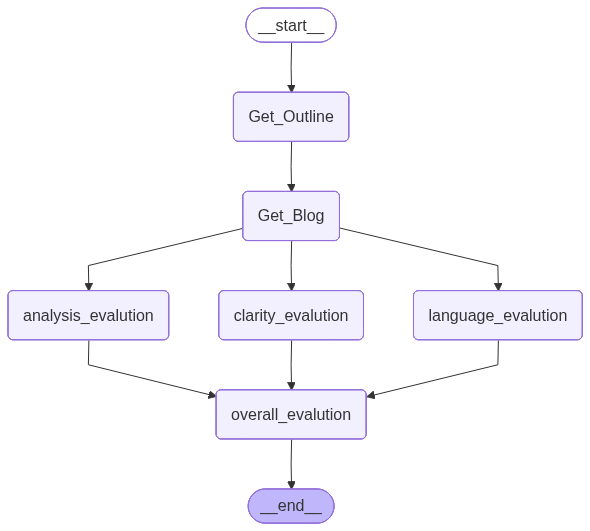

In [75]:
from IPython.display import Image
Image(blog_workflow.get_graph().draw_mermaid_png())

In [76]:
input_state = {'topic' : "Impact of AI in Tech Roles and recent layoffs"}
final_state = blog_workflow.invoke(input_state)
final_state

Running Analysis feedback
Running Clarity feedback
Running Language Feedback
[7, 7, 7]


{'topic': 'Impact of AI in Tech Roles and recent layoffs',
 'outline': "**Blog Outline: The Impact of AI on Tech Roles and Recent Layoffs**\n\n**I. Introduction**\n   A. Brief overview of the rise of AI in the technology sector\n   B. The interconnectedness of AI advancements and employment trends\n   C. Purpose of the blog: To explore how AI is shaping tech roles and its correlation with recent layoffs\n\n**II. Understanding AI and Its Implications in the Tech Industry**\n   A. Definition of Artificial Intelligence (AI) \n   B. Types of AI technologies impacting the tech sector\n      1. Machine Learning\n      2. Natural Language Processing\n      3. Automation and Robotics\n   C. Current trends in AI adoption in tech companies\n\n**III. The Transformation of Tech Roles due to AI**\n   A. Evolving job descriptions and skill requirements\n      1. Emergence of data science and AI-specific roles\n      2. Demand for AI and machine learning skills\n   B. Redefining traditional roles\n  

In [48]:
print(final_state.get("language_feedback"))

### Language-Related Feedback on the Blog Post

#### Grammar
The grammar in the blog post is generally strong, with correct usage of tenses and punctuation. However, there are a few areas that could benefit from minor adjustments for clarity or correctness:
- In the sentence "the tech industry has faced a wave of layoffs, leaving thousands without jobs," the "leaving" clause could be more clearly linked to the main clause. Consider rephrasing to "the tech industry has faced a wave of layoffs, which has left thousands without jobs."
- When mentioning a “staggering statistic from 2023,” it would be beneficial to contextualize this statistic with either the source or a clearer timeframe using "in," making it “a staggering statistic from the first quarter of 2023” instead.

#### Vocabulary Richness
The vocabulary used throughout the blog post is appropriate for the target audience. Terms like "plethora," "catalyzed," and "upskilling" suggest that the writer is knowledgeable about the subje